Diabetic Retinopathy

In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf 
import os
from keras.preprocessing.image import ImageDataGenerator
import efficientnet.tfkeras as efn
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import seaborn as sns

In [20]:
for dirname, _, filenames in os.walk('gaussian_filtered_images/images'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [21]:
# Function to calculate learning rate
def lr_rate(epoch, lr):
    if epoch < 5:
        lr = 0.0001
        return lr
    elif 5 <= epoch <= 10:
        lr = 0.00005
        return lr
    else:
        lr = lr * (epoch / (1 + epoch))
        return lr

In [22]:
datagen = ImageDataGenerator(rescale=1./255,
                                      zoom_range=0.2,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      validation_split=0.2
                                      )
train_data = datagen.flow_from_directory('gaussian_filtered_images/images',
                                                     target_size=(224,224),
                                                     batch_size=64,
                                                     class_mode = 'categorical',
                                                     subset = 'training')

valid_data = datagen.flow_from_directory('gaussian_filtered_images/images',
                                                     target_size=(224,224),
                                                     batch_size=64,
                                                     class_mode = 'categorical',
                                                     subset = 'validation')

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [27]:
# Get unique class labels from the data generator
class_labels = list(train_data.class_indices.keys())

# Calculate class weights for handling class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_data.classes), y=train_data.classes)
class_weights_dict = dict(zip(class_labels, class_weights))


TypeError: compute_class_weight() takes 1 positional argument but 3 were given

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_rate)

In [ ]:
# Build and compile the model
model = tf.keras.Sequential([
    efn.EfficientNetB4(
        input_shape=(224,224, 3),
        weights='imagenet',
        include_top=False
    ),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['acc'])

KeyboardInterrupt: 

In [ ]:
# Train the model
history = model.fit_generator(train_data,
                              validation_data=valid_data,
                              class_weight=class_weights_dict,
                              callbacks=[lr_callback, early_stop],
                              epochs=15,
                              verbose=1
                             )

C:\Users\AyhanÇavdar\AppData\Local\Temp\ipykernel_7752\3742900865.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_data,validation_data = valid_data,callbacks=[reduce_lr, early_stop],epochs=5,verbose=1)


Epoch 1/5


92/92 [==============================] - 248s 2s/step - loss: 1.0144 - acc: 0.6718 - val_loss: 0.8735 - val_acc: 0.7004 - lr: 0.0010
Epoch 2/5
92/92 [==============================] - 251s 3s/step - loss: 0.6537 - acc: 0.7537 - val_loss: 0.7063 - val_acc: 0.7373 - lr: 0.0010
Epoch 3/5
92/92 [==============================] - 250s 3s/step - loss: 0.5923 - acc: 0.7741 - val_loss: 0.8964 - val_acc: 0.6895 - lr: 0.0010
Epoch 4/5
92/92 [==============================] - 255s 3s/step - loss: 0.5310 - acc: 0.8011 - val_loss: 0.6008 - val_acc: 0.7715 - lr: 0.0010
Epoch 5/5
92/92 [==============================] - 269s 3s/step - loss: 0.4965 - acc: 0.8178 - val_loss: 0.6839 - val_acc: 0.7688 - lr: 0.0010


In [ ]:
# Plot training curves
def display_training_curves(training, validation, title, subplot):
    if subplot % 10 == 1:
        plt.subplots(figsize=(10, 10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model ' + title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

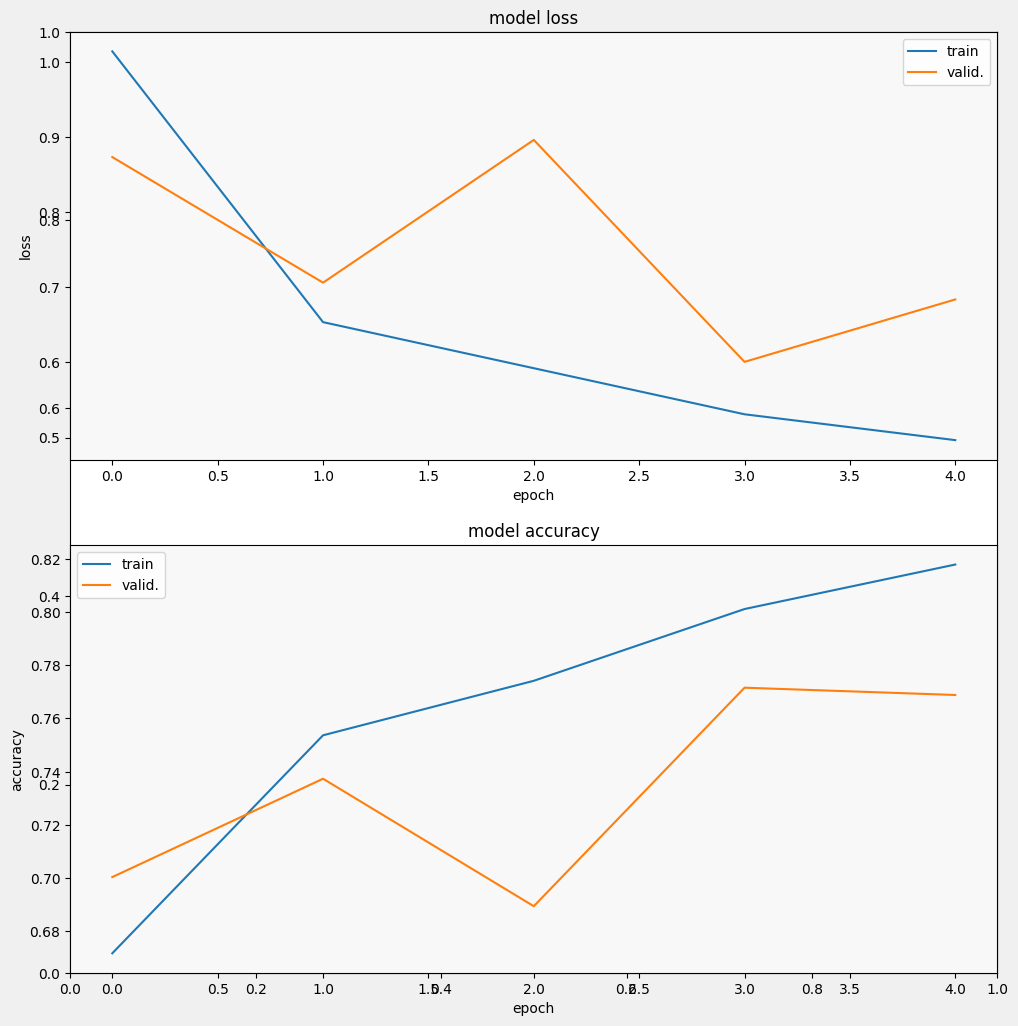

In [ ]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211
)

display_training_curves(
    history.history['acc'],
    history.history['val_acc'],
    'accuracy',
    212
)

23/23 [==============================] - 14s 600ms/step
F1 score: 0.17489657715478796
AUC: 0.4957909721230275


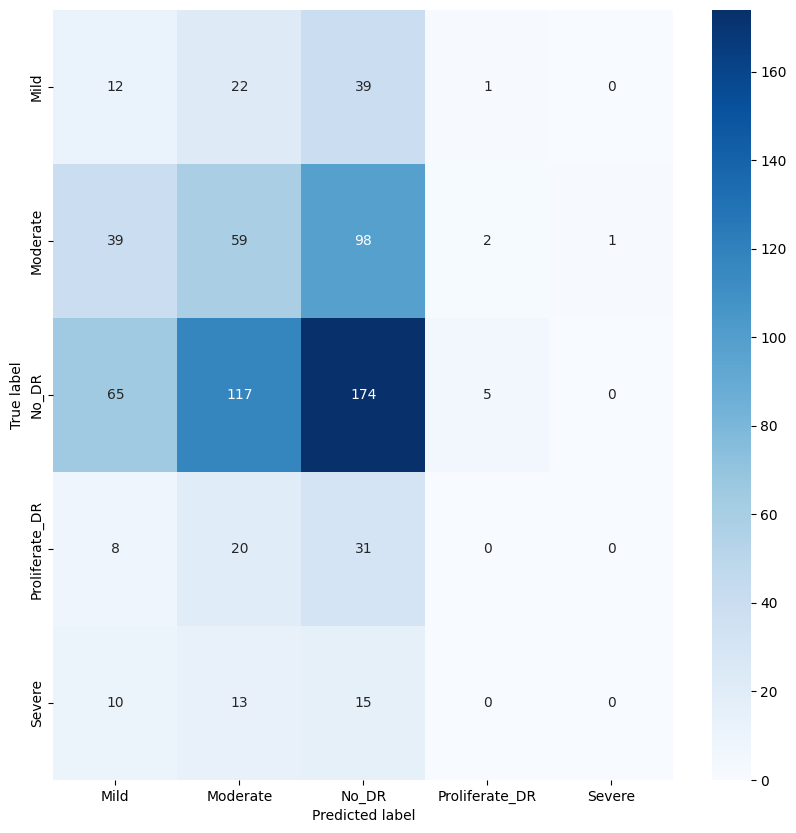

In [ ]:
# Evaluate the model
y_actual = valid_data.labels
y_predicted_prob = model.predict(valid_data)
y_predicted = np.argmax(y_predicted_prob, axis=1)

# Calculate the F1 score and AUC
f1 = f1_score(y_actual, y_predicted, average='macro')
auc = roc_auc_score(y_actual, y_predicted_prob, average='macro', multi_class='ovo')

# Print the results
print('F1 score:', f1)
print('AUC:', auc)

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_actual, y_predicted)

# Define the class names
class_names = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

# Plot the confusion matrix with labels
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()